In [1]:
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pandas as pd

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


In [2]:
dic_country = \
{'AUS': 'Australia',
 'BRA': 'Brazil',
 'CAN': 'India',
 'CHN': 'China',
 'GBR': 'United Kingdom',
 'IND': 'India',
 'JPN': 'Japan',
 'SGP': 'Singapore',
 'USA': 'United States'}


datas_m_raw = pd.ExcelFile('../../Data/cleaned/Manufacturing_filled.xlsx')
datas_s_raw = pd.ExcelFile('../../Data/cleaned/Service_filled.xlsx')
datas_m = {}
datas_s = {}
for con in dic_country.keys():
    datas_m[con] = pd.read_excel(datas_m_raw, sheet_name=con)
    datas_m[con]['Year'] = datas_m[con]['Year'].astype('int')
    datas_s[con] = pd.read_excel(datas_s_raw, sheet_name=con)
    datas_s[con]['Year'] = datas_s[con]['Year'].astype('int')
pd.DataFrame(dic_country,index=[0]).T.reset_index().rename(columns = {'index': 'country_code', 0: 'country_name'})

,country_code,country_name
0,AUS,Australia
1,BRA,Brazil
2,CAN,India
3,CHN,China
4,GBR,United Kingdom
5,IND,India
6,JPN,Japan
7,SGP,Singapore
8,USA,United States


**Notes:**
- Properly scale the dataset.
- Robust prior setting that can pass sanity check.
- Allow changepoints

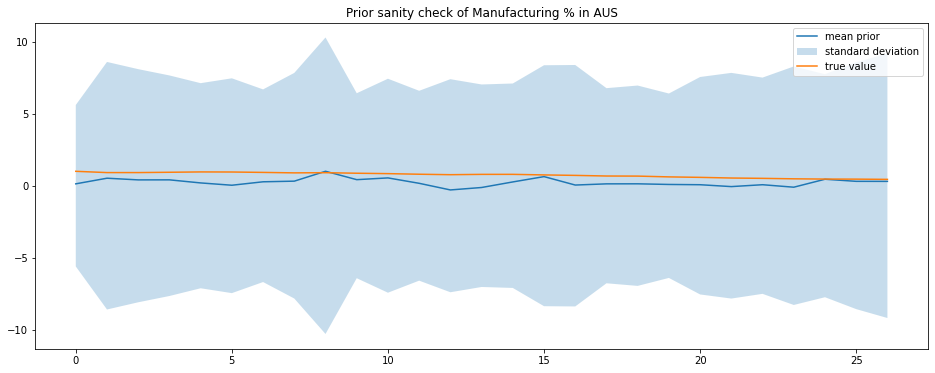

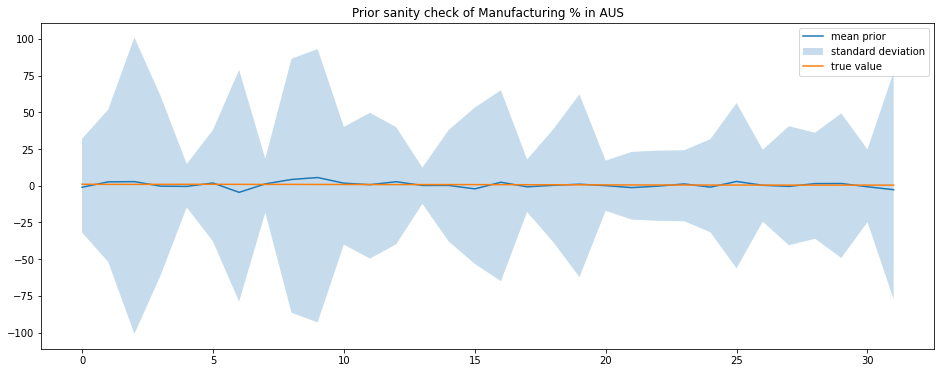

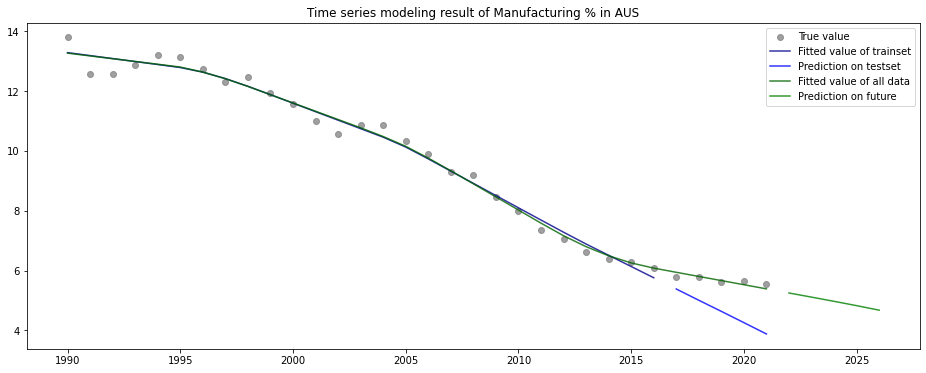

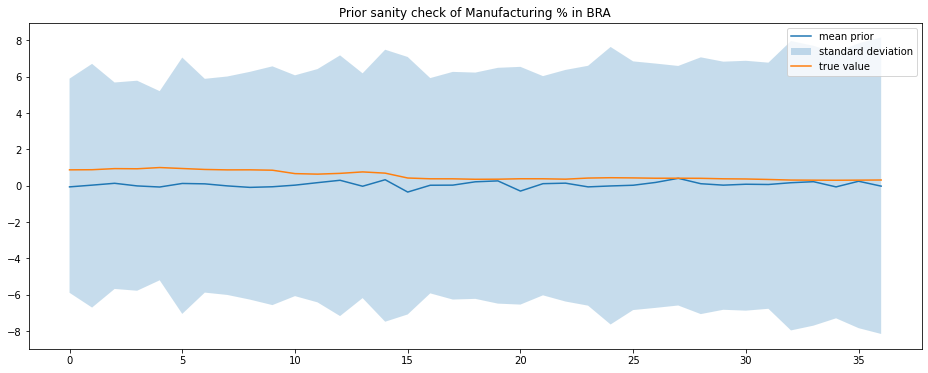

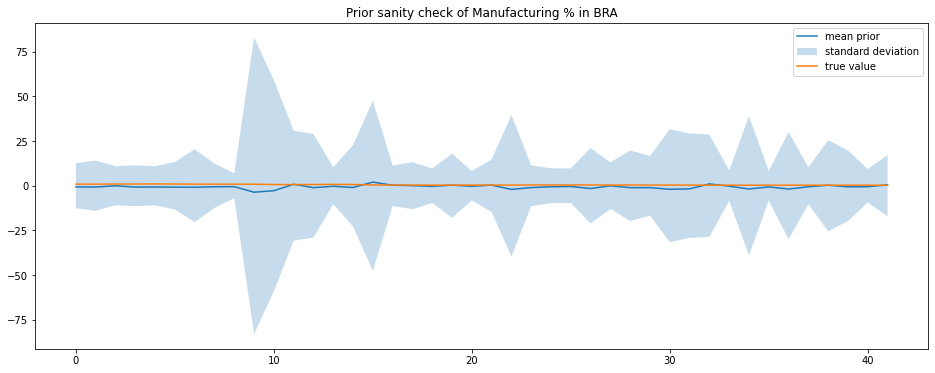

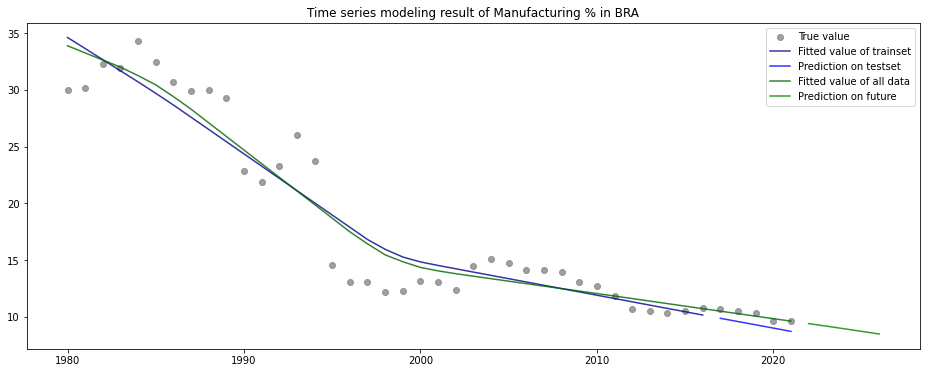

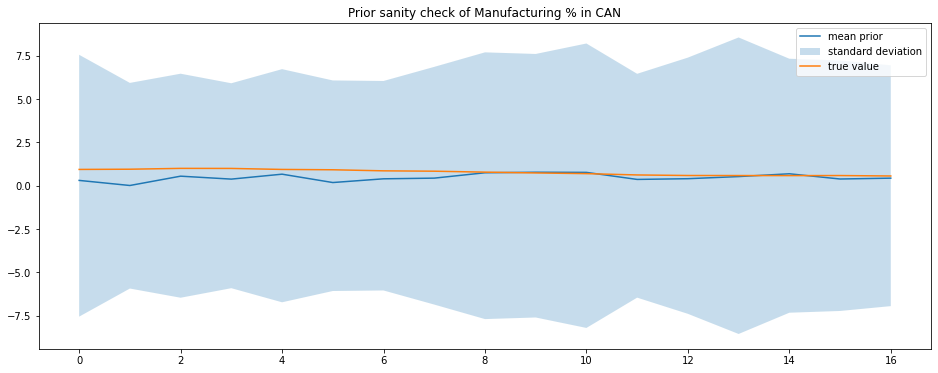

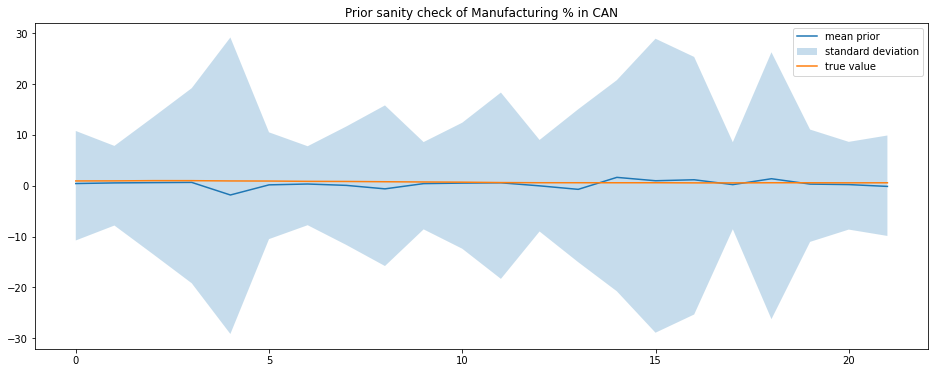

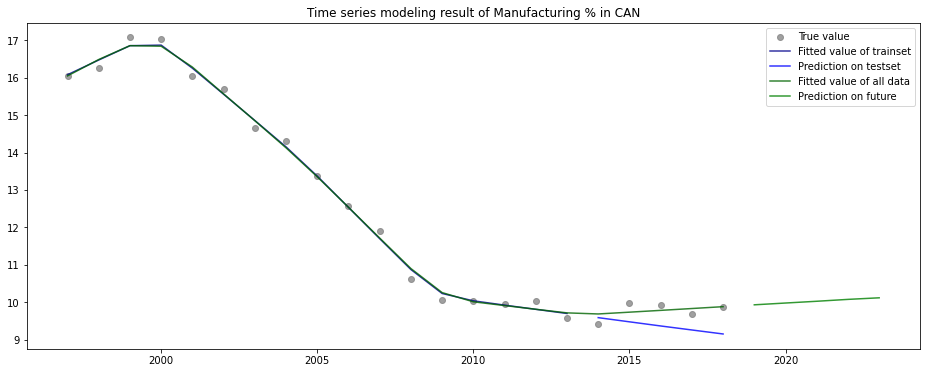

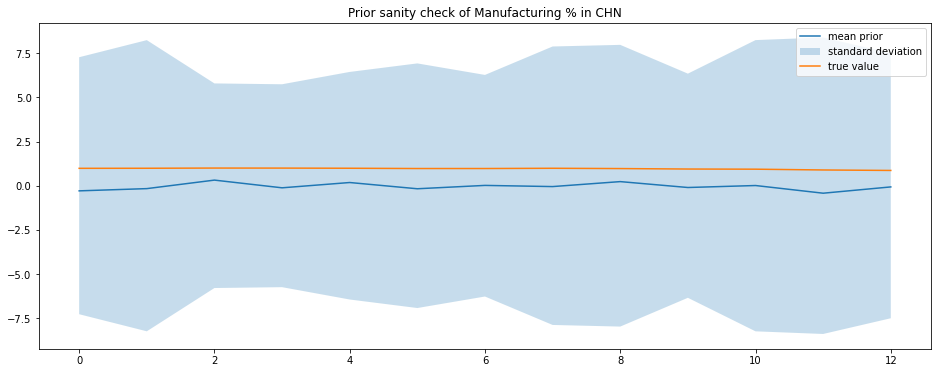

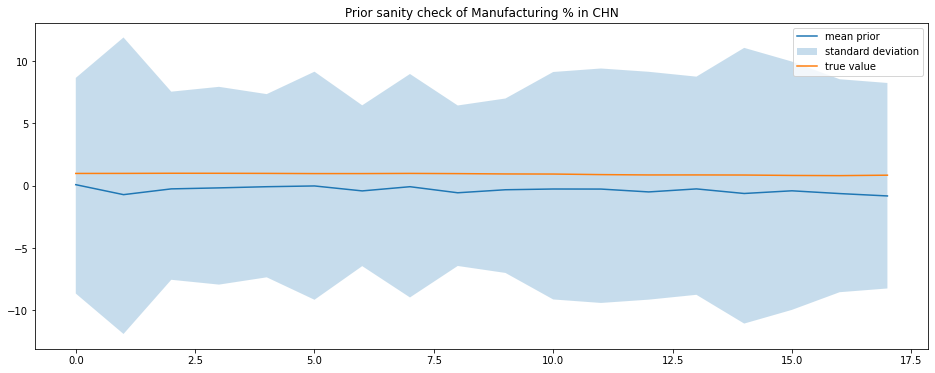

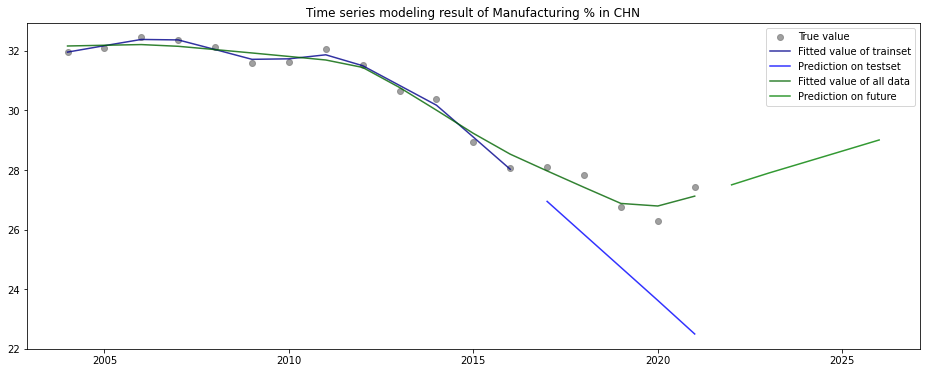

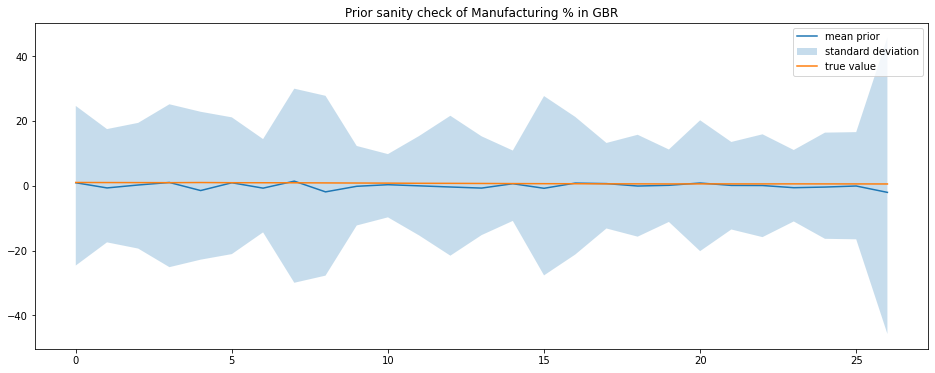

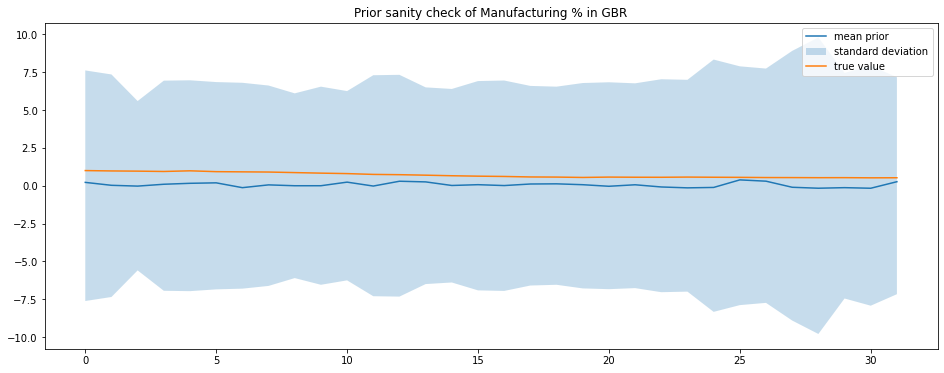

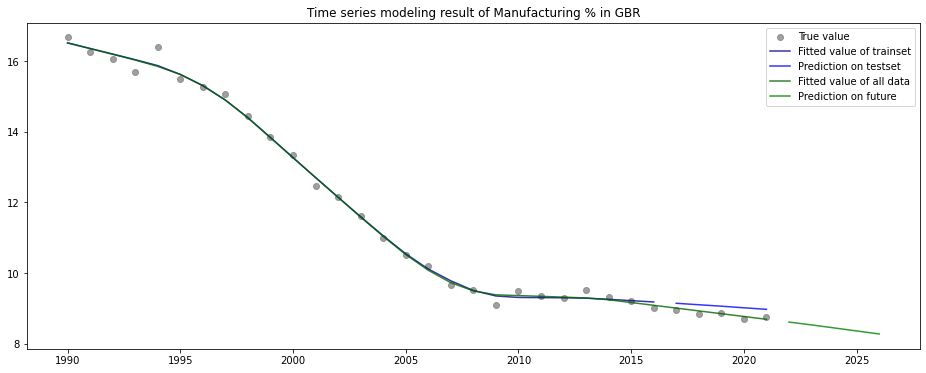

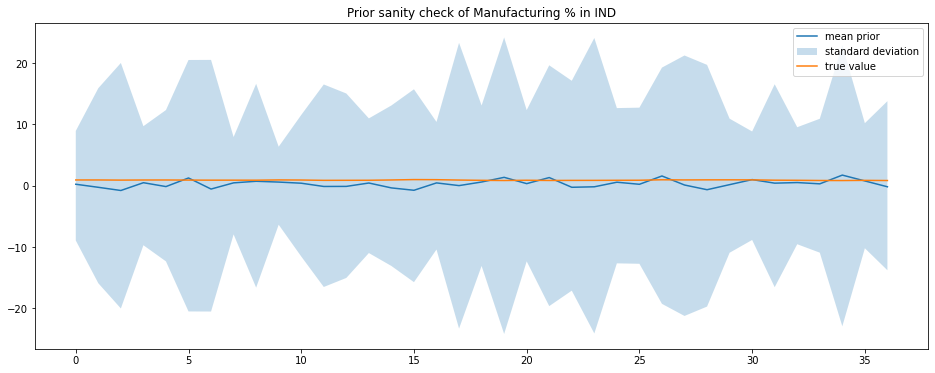

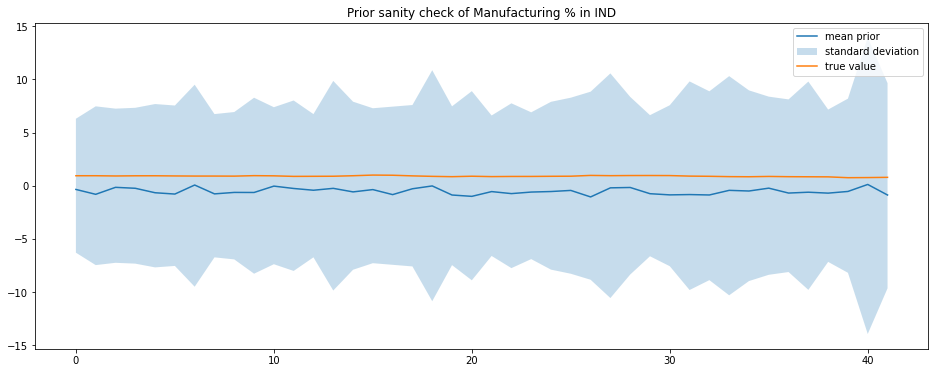

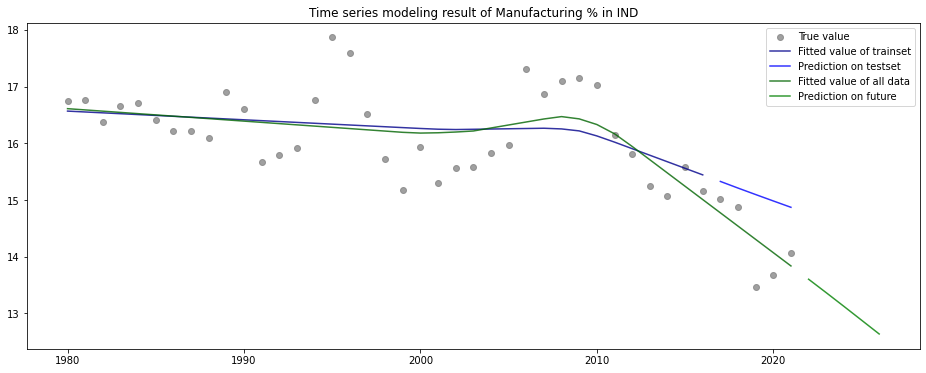

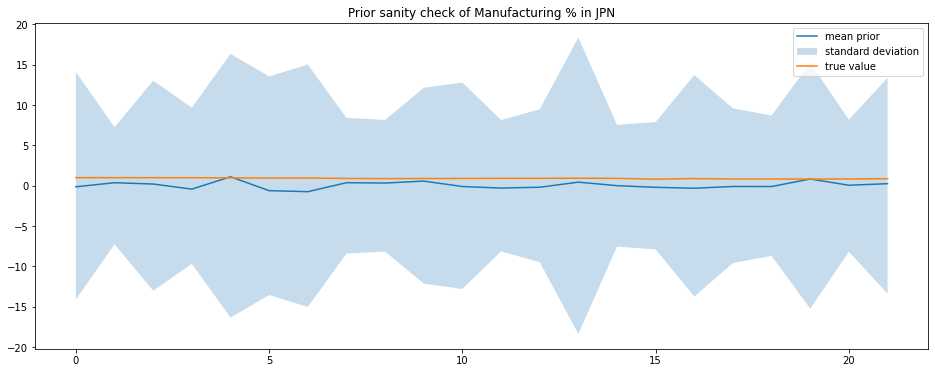

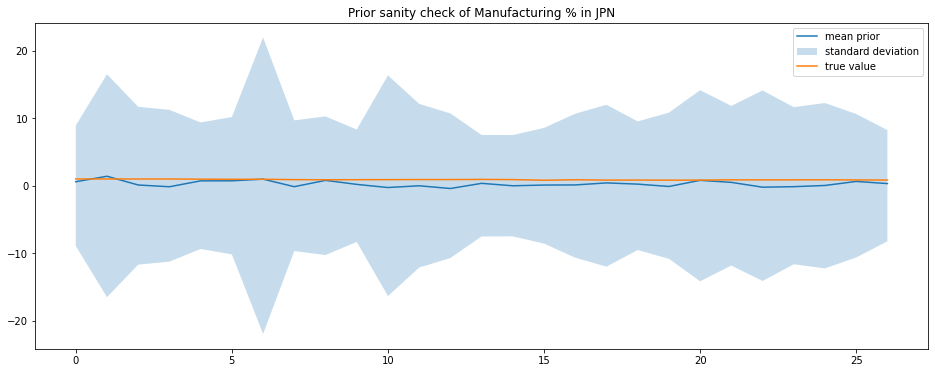

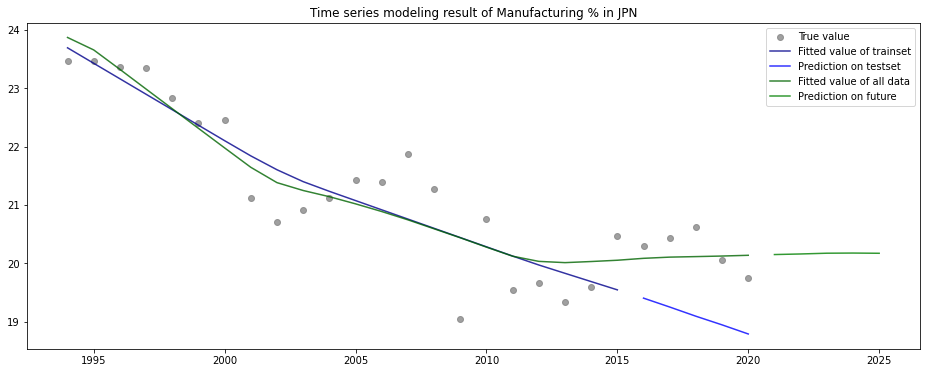

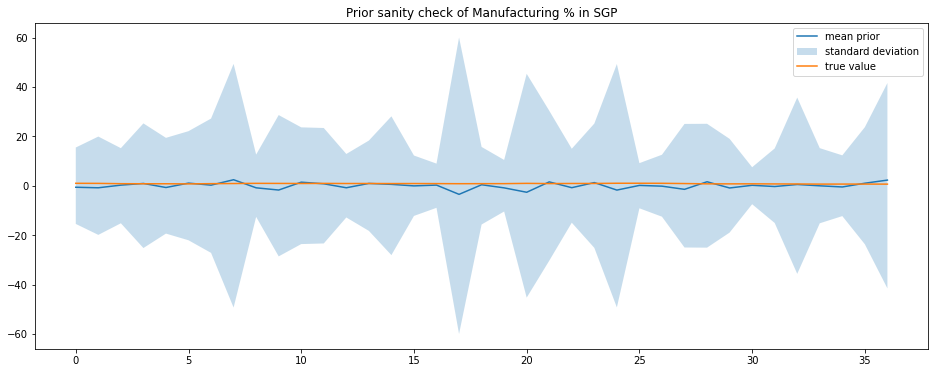

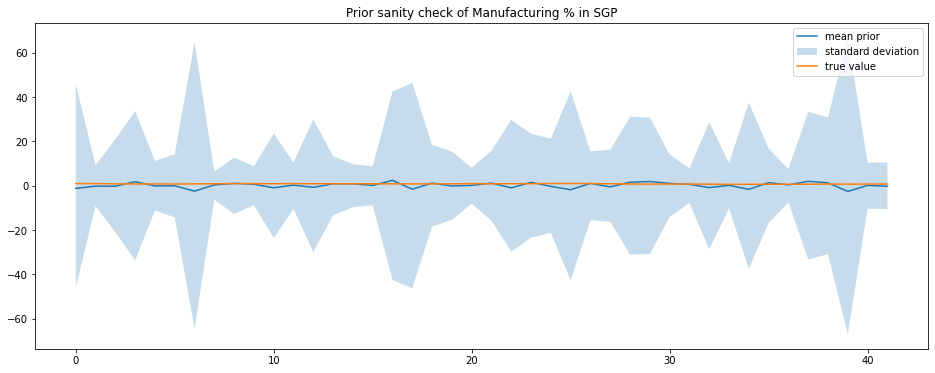

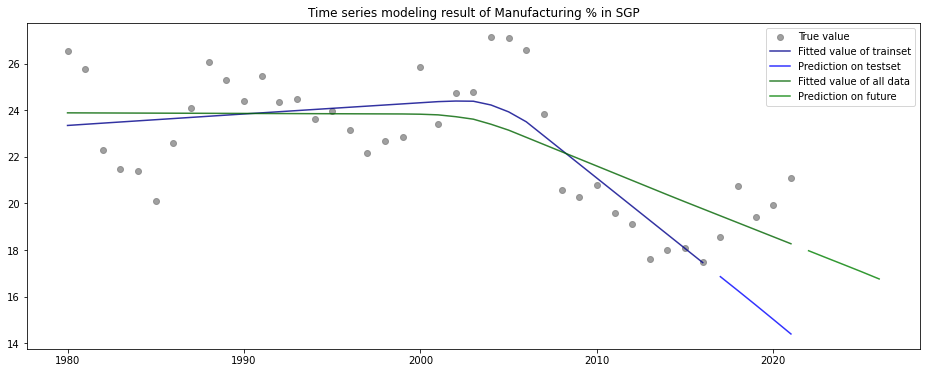

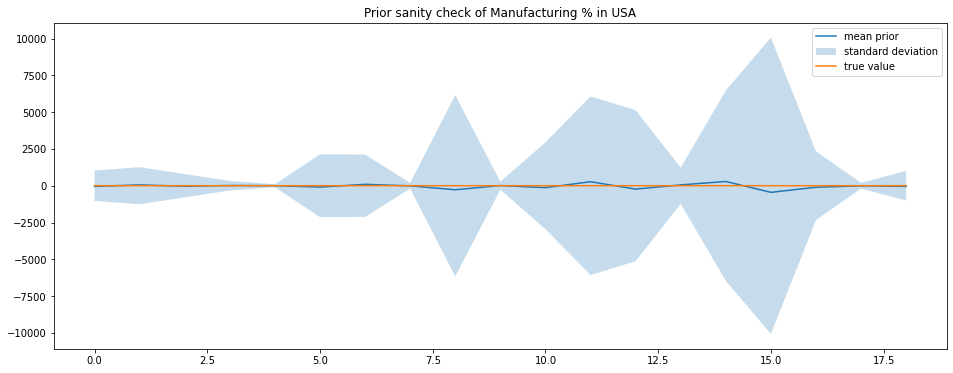

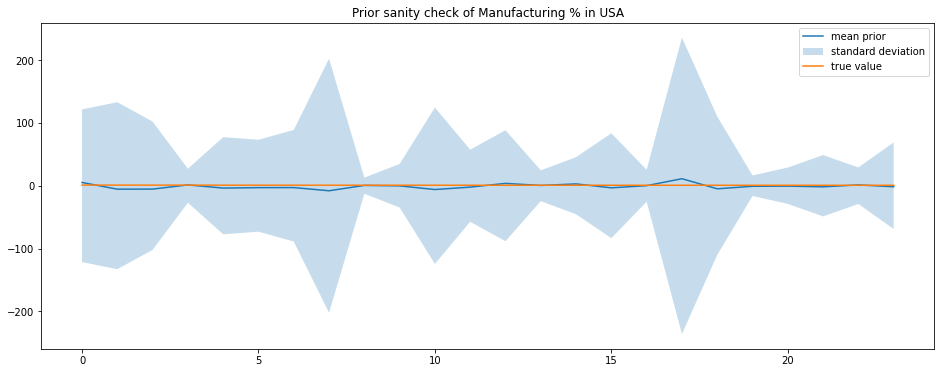

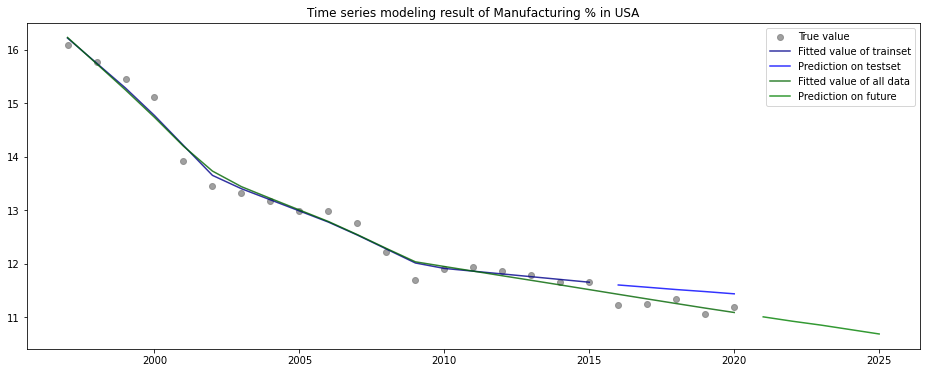

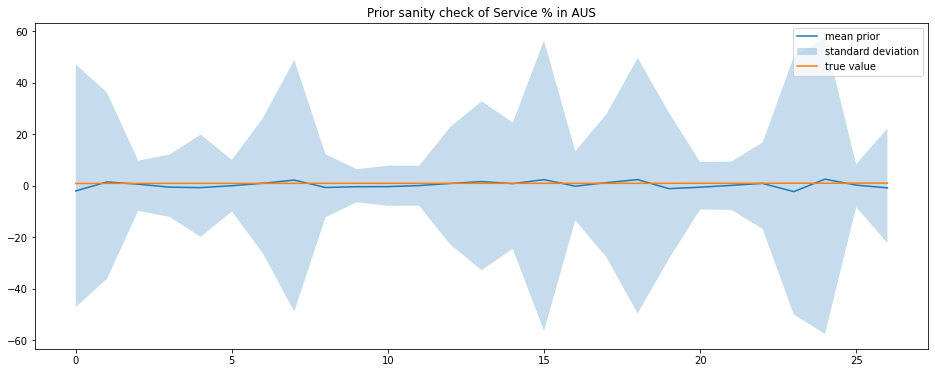

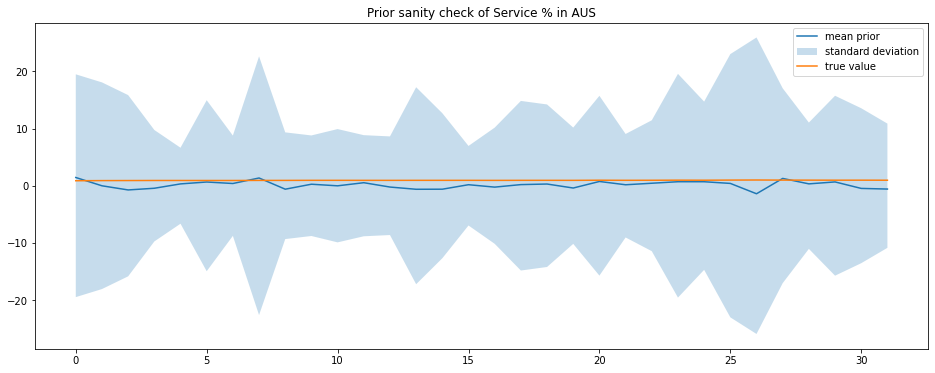

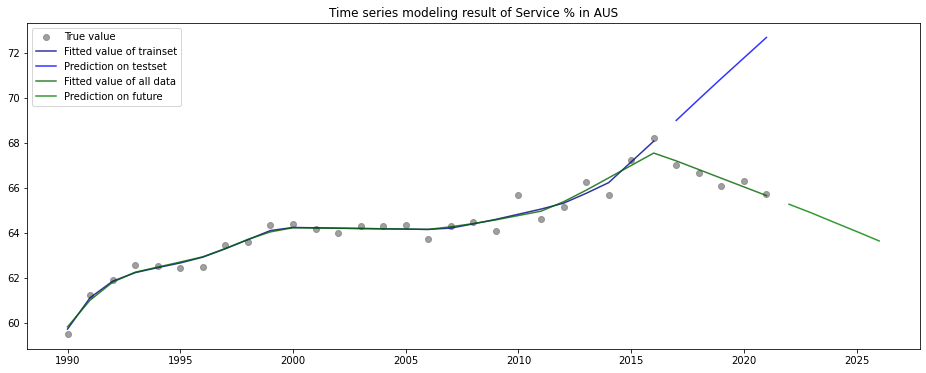

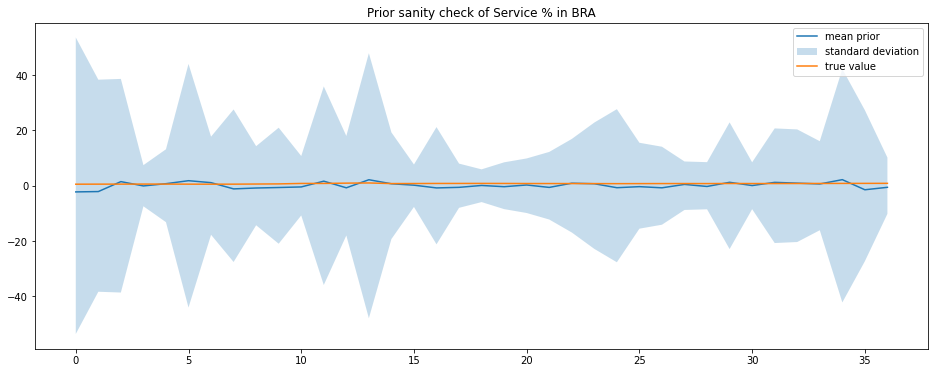

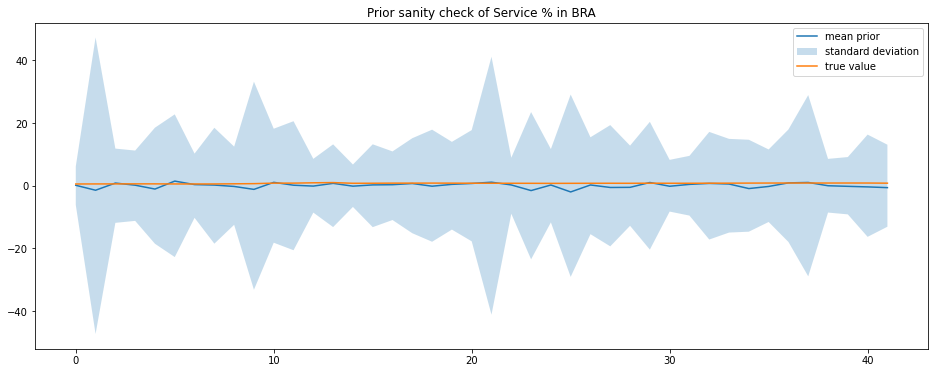

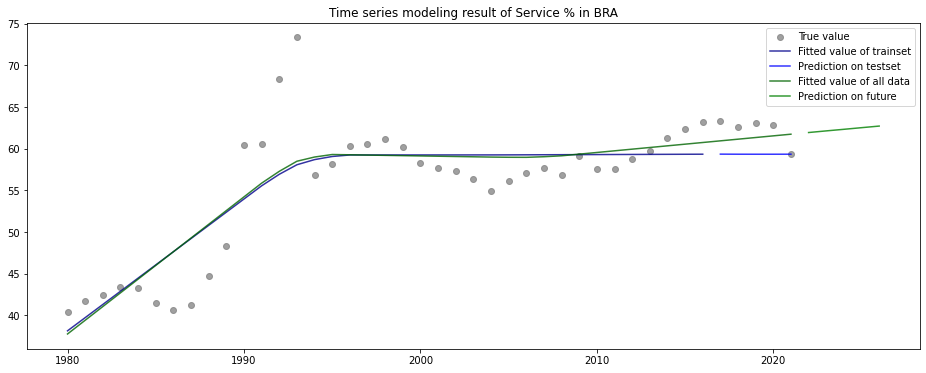

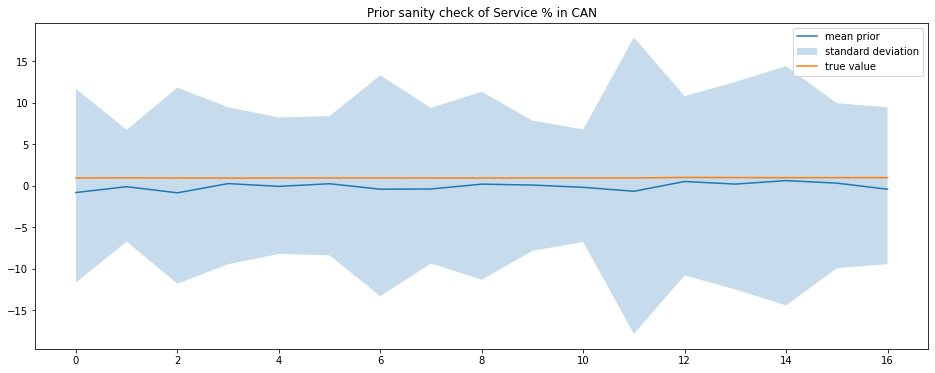

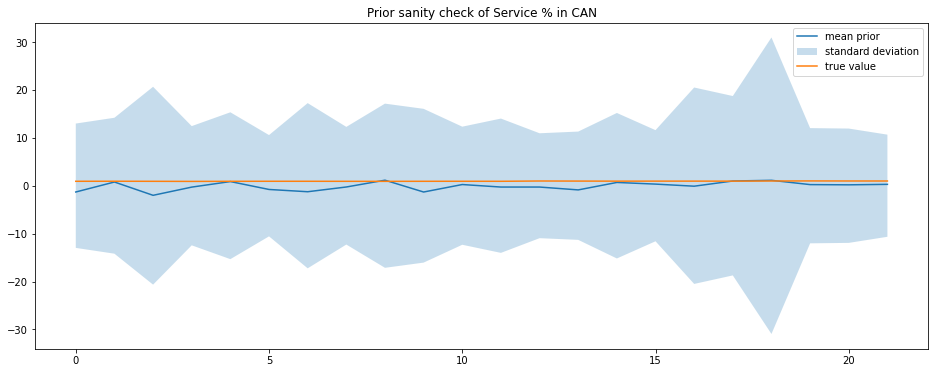

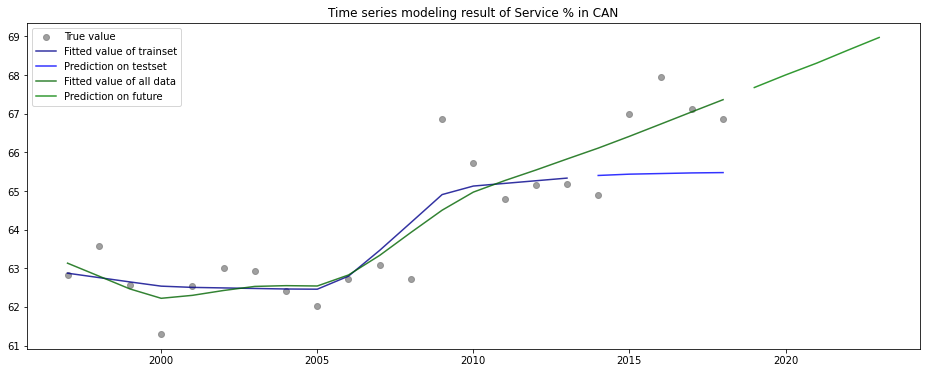

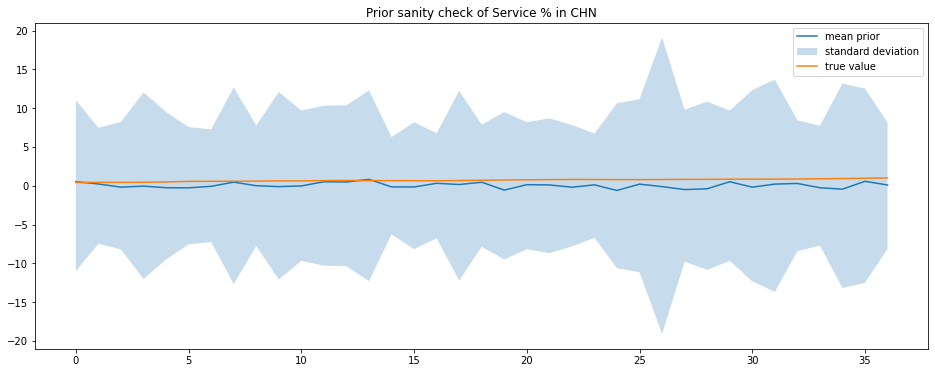

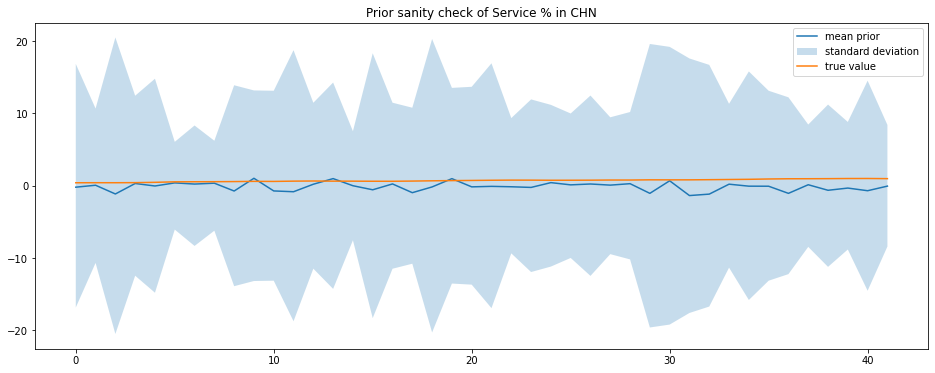

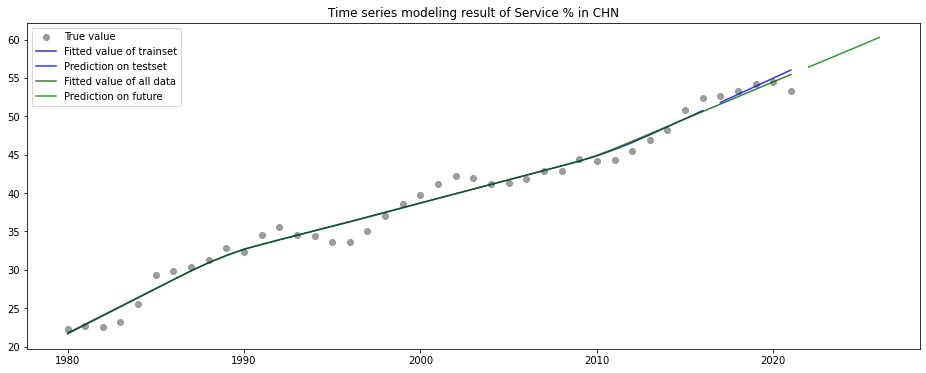

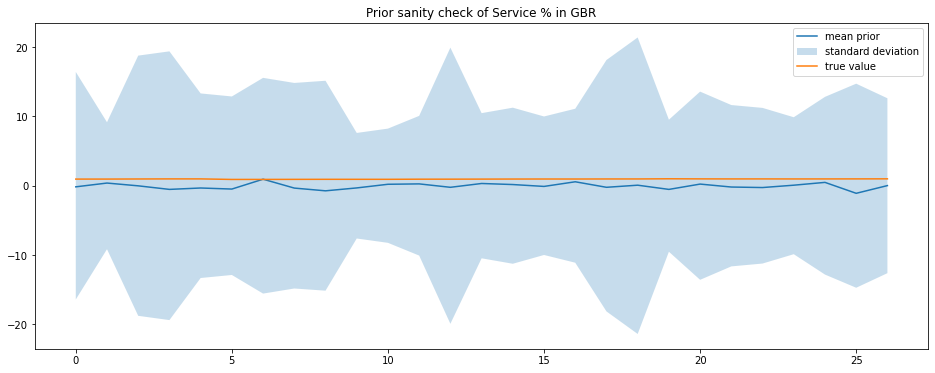

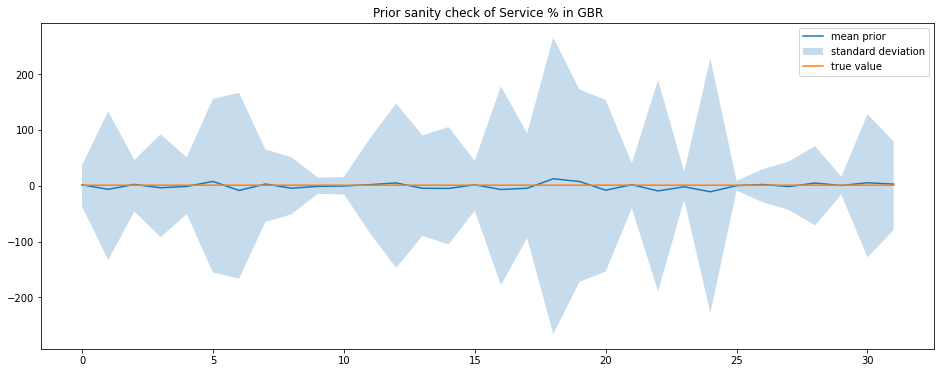

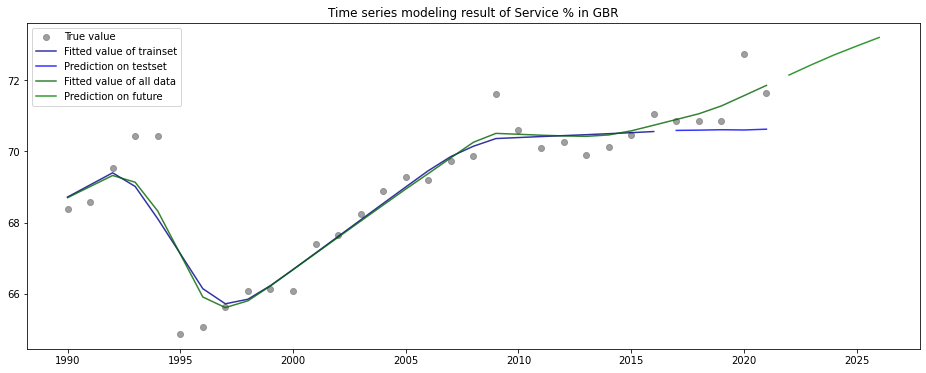

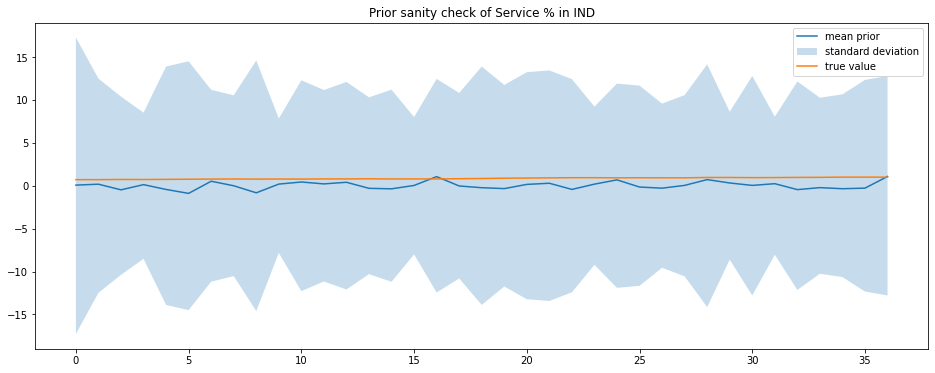

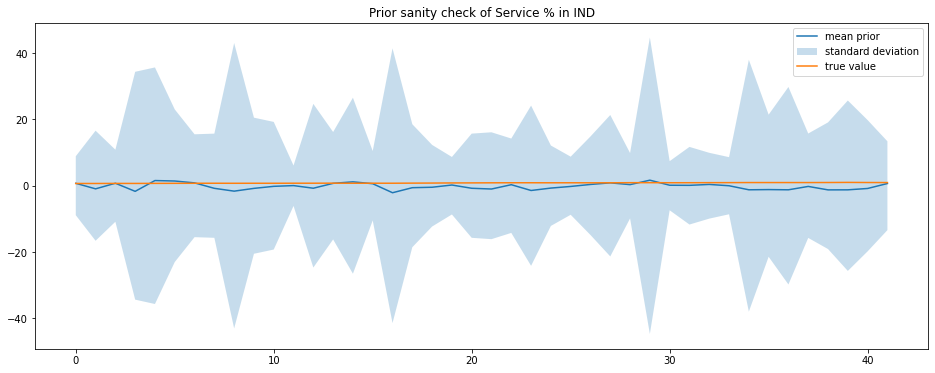

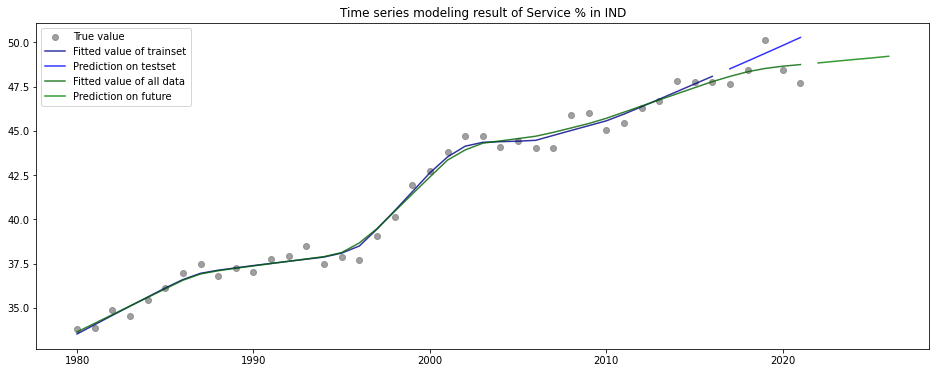

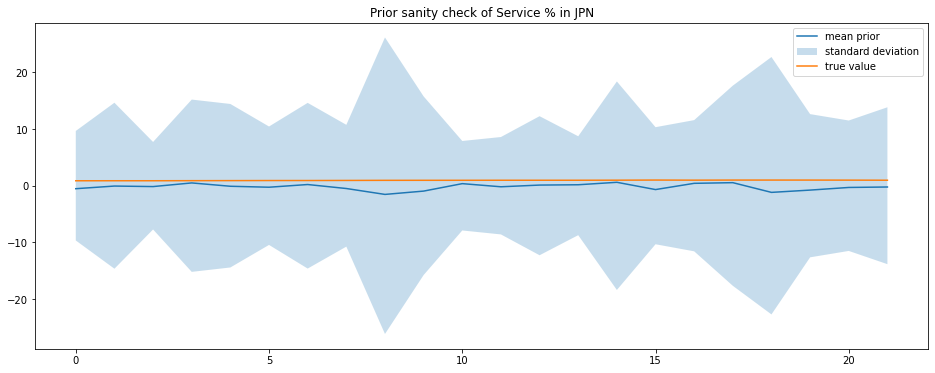

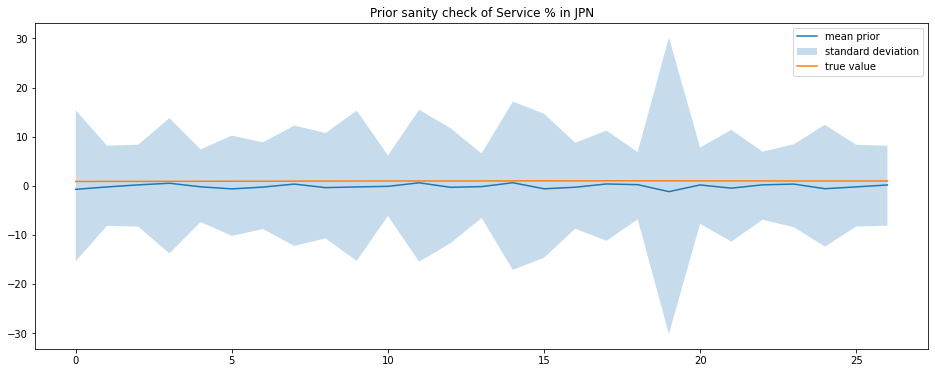

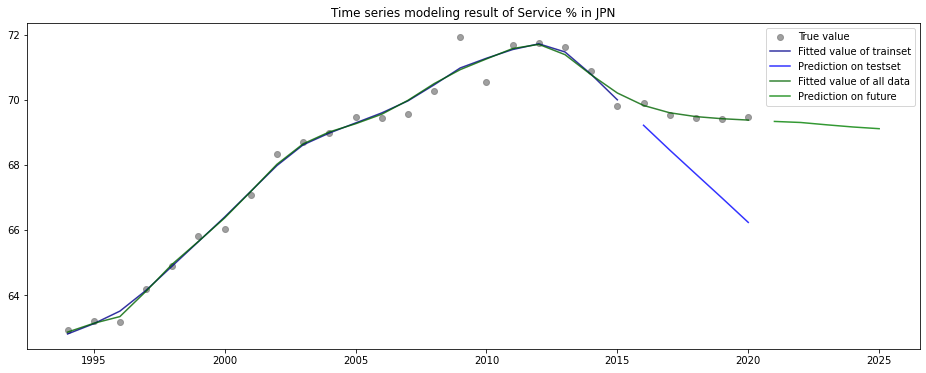

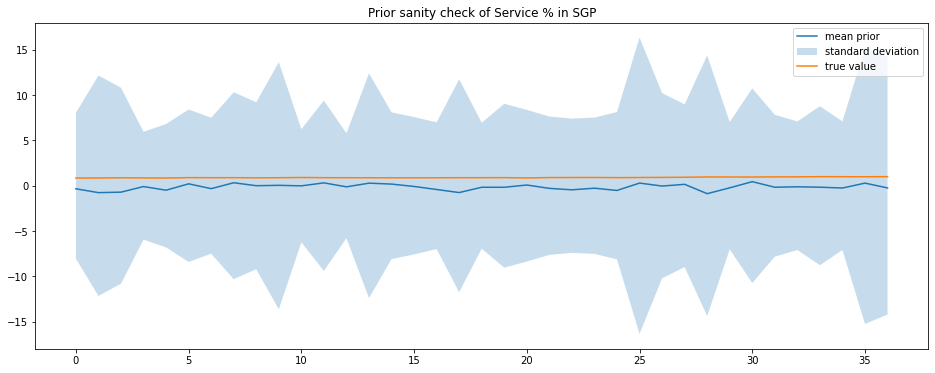

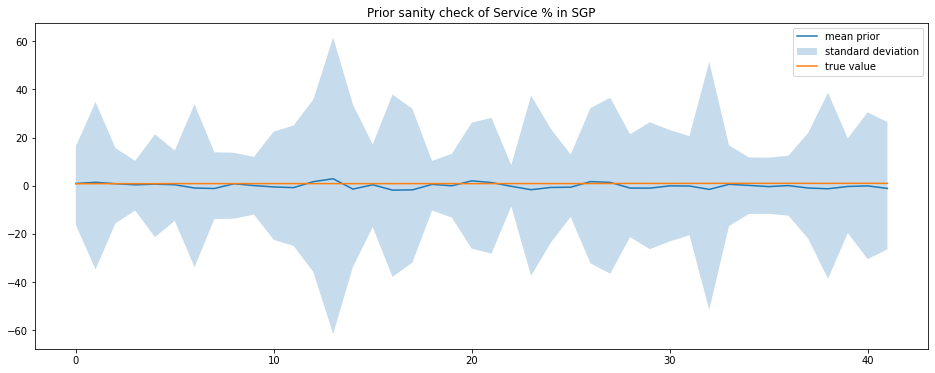

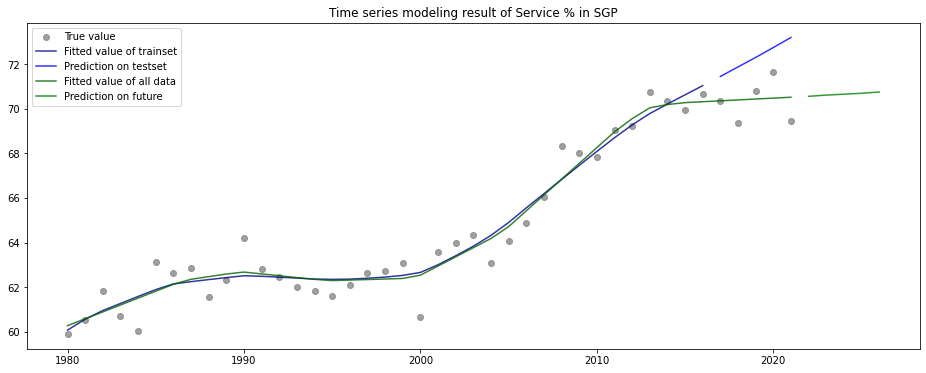

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)




IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)




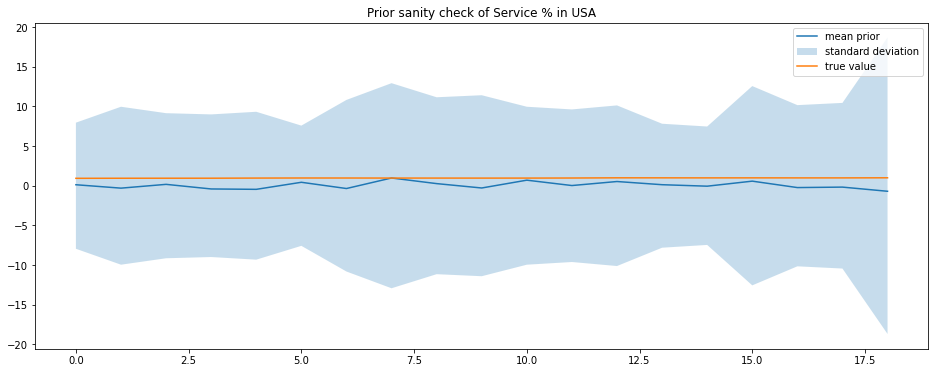

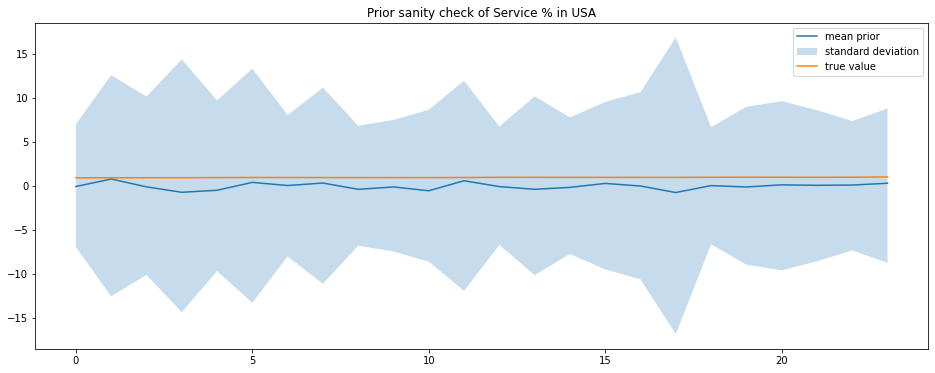

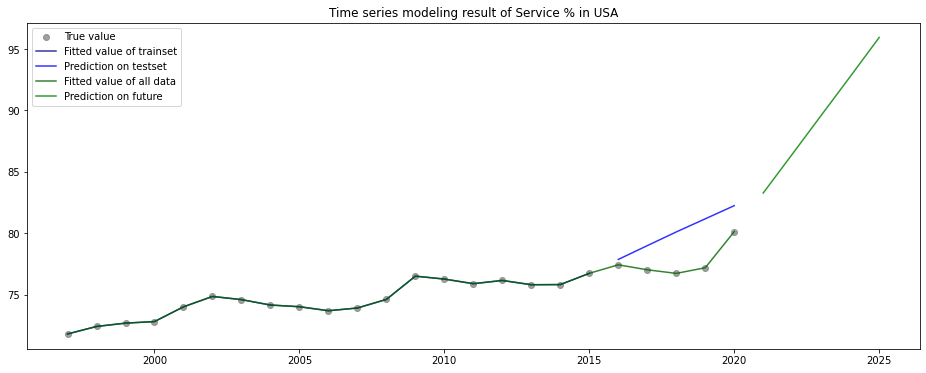

In [5]:
N_CHANGE_POINTS = 25
def det_dot(a, b):
    """
    The theano dot product and NUTS sampler don't work with large matrices?
    
    :param a: (np matrix)
    :param b: (theano vector)
    """
    return (a * b[None, :]).sum(axis=-1)

def trend_model(m, t, n_changepoints=N_CHANGE_POINTS, changepoints_prior_scale=0.15,
                growth_prior_scale=5, changepoint_range=1):
    """
    The piecewise linear trend with changepoint implementation in PyMC3.
    :param m: (pm.Model)
    :param t: (np.array) MinMax scaled time.
    :param n_changepoints: (int) The number of changepoints to model.
    :param changepoint_prior_scale: (flt/ None) The scale of the Laplace prior on the delta vector.
                                    If None, a hierarchical prior is set.
    :param growth_prior_scale: (flt) The standard deviation of the prior on the growth.
    :param changepoint_range: (flt) Proportion of history in which trend changepoints will be estimated. 
    :return g, A, s: (tt.vector, np.array, tt.vector)
    """
    s = np.linspace(0, changepoint_range * np.max(t), n_changepoints + 1)[1:]
    
    # * 1 casts the boolean to integers
    A = (t[:, None] > s) * 1

    with m:
        # initial growth
        k = pm.Normal('k', 0 , growth_prior_scale)
        
        if changepoints_prior_scale is None:
            changepoints_prior_scale = pm.Exponential('tau', 1.5)
        
        # rate of change
        delta = pm.Laplace('delta', 0, changepoints_prior_scale, shape=n_changepoints)
        # offset
        m = pm.Normal('m', 0, 5)
        gamma = -s * delta
        
        g = (k + det_dot(A, delta)) * t + (m + det_dot(A, gamma))
    return g, A, s, changepoints_prior_scale

def sanity_check(m, y_true, title):
    """
    :param m: (pm.Model)
    :param y_true: (np.arrary)
    :param title: (str)
    """
    # Sample from the prior and check of the model is well defined.
    y = pm.sample_prior_predictive(model=m)['obs']
    plt.figure(figsize=(16, 6))
    plt.plot(y.mean(0), label='mean prior')
    plt.fill_between(np.arange(y.shape[1]), -y.std(0), y.std(0), alpha=0.25, label='standard deviation')
    plt.plot(y_true, label='true value')
    plt.title(title)
    plt.legend()

# Determine g, based on the parameters
def det_trend(k, m, delta, t, s, A):
    return (k + np.dot(A, delta)) * t + (m + np.dot(A, (-s * delta)))


for task, y_label, data_contries in [
    ('Manufacturing', "Manufacturing_value added_%_of_GDP", datas_m),                                 
    ('Service', "Services_value_added_%_of_GDP", datas_s)
]:    

    for con in list(dic_country.keys()):
        # -----Data Formating----
        data = data_contries[con]
        y_all = data[y_label]
        y_all_max = y_all.max()
        y_all_scaled = y_all / y_all_max
        t_all = (data['Year'] - data['Year'].min()) / (data['Year'].max() - data['Year'].min())
        
        # Convert last 5 years as test set to be evaluated
        df_train = data[:-5]
        y_train = df_train[y_label]
        y_train_max = np.max(y_train)
        y_train_scaled = y_train / y_train_max
        t_train = t_all[:len(y_train)]
        
        df_test = data[-5:]
        y_test = df_test[y_label]
        t_test = t_all[len(y_train):]

        # predict future 5 years
        N_PREDICT = 5
        df_future = pd.DataFrame({'Year': range(data['Year'].max() + 1, data['Year'].max() + 1 + N_PREDICT)})
        t_future = (df_future['Year'] - data['Year'].min()) / (data['Year'].max() - data['Year'].min())
        
        # -----Validation-----
        # Generate a PyMC3 Model context
        m = pm.Model()

        with m:
            y, A, s, changepoints_prior_scale = trend_model(m, np.array(t_train))
            sigma = pm.HalfCauchy('sigma', 0.5, testval=1)
            pm.Normal('obs', 
                      mu=y,
                      sd=sigma,
                      observed=y_train_scaled)

        # Run the sanity check
        sanity_check(m, y_true=y_train_scaled, title = f'Prior sanity check of {task} % in {con}')

        # Find a point estimate of the models parameters
        with m:
            aprox = pm.find_MAP()

        # Run function and rescale to original scale
        g_fitted = det_trend(aprox['k'], aprox['m'], aprox['delta'], t_train, s, A) * y_train_max
        #g_pred = det_trend(aprox['k'], aprox['m'], aprox['delta'], t_test, s, A) * y_train_max
        
        # Predict on the validation set
        trend_forecast = []
        probability_changepoint = N_CHANGE_POINTS / df_train.shape[0]
        n_samples = 1000
        for n in range(n_samples):
            new_changepoints = t_test
            sample = np.random.random(new_changepoints.shape)
            new_changepoints = new_changepoints[sample <= probability_changepoint]
            new_delta = np.r_[aprox['delta'],
                              stats.laplace(0, changepoints_prior_scale).rvs(new_changepoints.shape[0])]
            new_s = np.r_[s, new_changepoints]
            new_A = (np.array(t_test)[:, None] > new_s) * 1
            g_pred_sample = det_trend(aprox['k'], aprox['m'], new_delta, t_test, new_s, new_A)
            trend_forecast.append(g_pred_sample)
        g_pred = np.array(trend_forecast).mean(0) * y_train_max


        # -----Deplotement-----
        # Generate a PyMC3 Model context
        m = pm.Model()

        with m:
            y, A, s, changepoints_prior_scale = trend_model(m, np.array(t_all))
            sigma = pm.HalfCauchy('sigma', 0.5, testval=1)
            pm.Normal('obs', 
                      mu=y,
                      sd=sigma,
                      observed=y_all_scaled)

        # Run the sanity check
        sanity_check(m, y_true=y_all_scaled, title = f'Prior sanity check of {task} % in {con}')

        # Find a point estimate of the models parameters
        with m:
            aprox = pm.find_MAP()

        # Run function and rescale to original scale
        g_fitted_all = det_trend(aprox['k'], aprox['m'], aprox['delta'], t_all, s, A) * y_all_max
        
        # Predict on the validation set
        trend_forecast = []
        probability_changepoint = N_CHANGE_POINTS / df_train.shape[0]
        n_samples = 1000
        for n in range(n_samples):
            new_changepoints = t_future
            sample = np.random.random(new_changepoints.shape)
            new_changepoints = new_changepoints[sample <= probability_changepoint]
            new_delta = np.r_[aprox['delta'], 
                              stats.laplace(0, changepoints_prior_scale).rvs(new_changepoints.shape[0])]
            new_s = np.r_[s, new_changepoints]
            new_A = (np.array(t_future)[:, None] > new_s) * 1
            g_pred_sample = det_trend(aprox['k'], aprox['m'], new_delta, t_future, new_s, new_A)
            trend_forecast.append(g_pred_sample)
        g_future_pred = np.array(trend_forecast).mean(0) * y_all_max

        # Show All
        plt.figure(figsize=(16, 6))
        plt.scatter(data['Year'], data[y_label], label='True value', color='gray', alpha=0.75)
        plt.plot(df_train['Year'], g_fitted, label='Fitted value of trainset', color='darkblue', alpha=0.8)
        plt.plot(df_test['Year'], g_pred, label='Prediction on testset', color='blue', alpha=0.8)
        plt.plot(data['Year'], g_fitted_all, label='Fitted value of all data', color='darkgreen', alpha=0.8)
        plt.plot(df_future['Year'], g_future_pred, label='Prediction on future', color='green', alpha=0.8)
        plt.legend()
        plt.title(f'Time series modeling result of {task} % in {con}')
        plt.show()
        # plt.plot(g_pred)
        # plt.scatter(np.arange(df_test.shape[0]), y_test, s=0.5, color='black')